In [1]:
import time
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install matplotlib
import numpy as np
import pandas as pd
flowdata = pd.read_excel(r'./flowdata.xlsx', sheet_name='Scenario1')
d2 = pd.read_excel(r'./flowdata.xlsx', sheet_name='Scenario2')
d3 = pd.read_excel(r'./flowdata.xlsx', sheet_name='Scenario3')
d4 = pd.read_excel(r'./flowdata.xlsx', sheet_name='Scenario5')
flowdata = flowdata.append(d2, ignore_index=True)
flowdata = flowdata.append(d3, ignore_index=True)
flowdata = flowdata.append(d4, ignore_index=True)
flowdata = flowdata[['KTB', 'KTC', 'SKB', 'SKC']] # ensure columns ordering is correct

**Equation**:
$$w\times KTB+x\times KTC-y\times SKB-z\times SKC = m = KTB + KTC - SKB - SKC$$

where *m* is the observed mismatch between JRWW and SKL
- Each set of flow values observed for KTB, KTC, SKB, SKC can be geometrically represented as a line in 4-dimensional space mapped by w, x, y, z

$$w\times KTB+x\times KTC-y\times SKB-z\times SKC-(KTB + KTC - SKB - SKC)=0$$

- By iterating through *test_values* for w, x, y, z, we find the point (w,x,y,z) that minimises the sum of the distance between (w,x,y,z) and all the lines

$$\sum distance = \sum\frac{|w\times KTB+x\times KTC-y\times SKB-z\times SKC-(KTB + KTC - SKB - SKC)|}{\sqrt{KTB^2+KTC^2+SKB^2+SKC^2}}$$

- Find *num_results* number of sample points that provide the *num_results* lowest sum of distances
- Each of w, x, y, z is equal to $\frac{E}{1+E}$ where E is the actual flowmeter error

In [2]:
flowdata

,KTB,KTC,SKB,SKC
0,0.0,390.7,0.0,391.7
1,0.0,388.2,0.0,388.4
2,0.0,408.9,0.0,407.2
3,0.0,413.1,0.0,407.5
4,0.0,408.3,0.0,400.8
...,...,...,...,...
61,466.5,388.9,473.7,382.7
62,455.6,397.0,463.6,388.8
63,462.6,393.9,470.2,387.0
64,455.9,399.5,462.3,391.1


**Adjustable Parameters:**

In [3]:
# number of results to display at the end
num_results = 10
# error upper bound, lower bound and interval (in %)
lower_bound_error = -2
upper_bound_error = 2
error_interval = 0.2

***

In [4]:
# initialisation
test_values = np.arange(lower_bound_error/error_interval, upper_bound_error/error_interval + 1)/(100/error_interval)
# introduce offset to ensure that every value is unique
results_array = [[0, 0, 0, 0, 999999 - row_num] for row_num in range(num_results)]
results = pd.DataFrame(results_array, columns=['KTB E1(%)', 'KTC E2(%)', 'SKB E3(%)', 'SKC E4(%)', 'Sum of Distances'])

In [5]:
# prepare raw data
flowdata_temp = flowdata
# change the sign of SKB and SKC columns for simpler arithmetic
flowdata_temp['SKB'] *= -1
flowdata_temp['SKC'] *= -1
flowdata_array = flowdata_temp.to_numpy()

The following algorithm attempts to find the best values of flowmeter errors E1, E2, E3, E4 that minimise the sum of the smallest euclidean distances between the final solution point and the lines formed by all the data provided. The *num_results* best solutions are stored and displayed below.

In [6]:
%%time
# main algorithm
for E1 in test_values:
    w = E1/(1+E1)
    for E2 in test_values:
        x = E2/(1+E2)
        for E3 in test_values:
            y = E3/(1+E3)
            for E4 in test_values:
                z = E4/(1+E4)
                sum_of_dist = 0
                for params in flowdata_array:
                    m = sum(params) # mismatch
                    dist = abs(np.dot(params, [w,x,y,z]) - m)/np.linalg.norm(params)
                    sum_of_dist += dist
                if sum_of_dist < results['Sum of Distances'].max():
                    row_to_replace = results['Sum of Distances'].idxmax()
                    results.loc[row_to_replace] = [100*E1,100*E2,100*E3,100*E4,sum_of_dist]

CPU times: user 2min 38s, sys: 1.58 s, total: 2min 40s
Wall time: 2min 40s


In [7]:
results = results.sort_values(by='Sum of Distances')
results = results.set_axis(range(1,num_results+1))
results

,KTB E1(%),KTC E2(%),SKB E3(%),SKC E4(%),Sum of Distances
1,-1.4,2.0,0.0,0.4,0.157635
2,-1.6,1.8,-0.2,0.2,0.157961
3,-1.8,1.6,-0.4,0.0,0.158288
4,-1.2,2.0,0.2,0.4,0.158325
5,-2.0,1.4,-0.6,-0.2,0.158617
6,-1.4,1.8,0.0,0.2,0.158654
7,-1.6,1.6,-0.2,0.0,0.158984
8,-1.0,2.0,0.4,0.4,0.159013
9,-1.8,1.4,-0.4,-0.2,0.159315
10,-1.2,1.8,0.2,0.2,0.159344


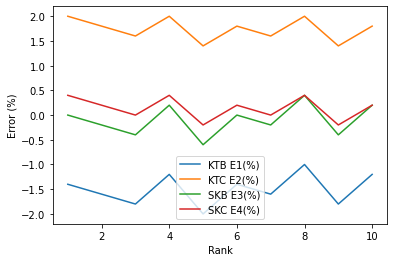

In [8]:
import matplotlib.pyplot as plt
error_plot_results = results[["KTB E1(%)","KTC E2(%)","SKB E3(%)","SKC E4(%)"]]
ax = error_plot_results.plot()
ax.set_xlabel("Rank")
ax.set_ylabel("Error (%)");